# GPT(Generative Pre-trained Transformer) 2

* 참고: https://github.com/NLP-kr/tensorflow-ml-nlp-tf2

GPT(Generative Pre-trained Transformer)
+ 2018.06 등장
+ 인코더 없이 디코더 블록을 12개 쌓아 모델을 구성  
  => 인코더가 없기 때문에 디코더 블록 내의 Encoder-Decoder Attention층을 제외하고,  
  Masked Self-Attention, Feed-Forward 2개의 sub-layer만 있다.

​
+ 기존 모델에서는 task에 맞춰 모델 구조를 변경하고 학습을 진행시켰다면,  
GPT에서는 Fine-tuning과정에서 데이터의 입력 방식을 변경하고,  
모델 구조는 일정하게 유지한다.

<img src=https://user-images.githubusercontent.com/45377884/112949500-408abc80-9174-11eb-8090-4f0be34db572.png width=600>

* OpenAI에서 GPT 모델 제안
* 매우 큰 자연어처리 데이터를 활용해 비지도 학습으로 사전 학습 후, 학습된 가중치를 활용해 파인 튜닝
* BERT와 마찬가지로 트랜스포머 모델이지만, BERT는 트랜스포머의 인코더 구조만 사용하고, GPT는 트랜스포머의 디코더 구조(순방향 어텐션)만 사용
+ LSTM, GRU를 사용한 기존 모델보다 자연어추론(NLI), 질의응답(QA), 분류(Classification) 등의 task에서 높은 성능을 보임



* GPT2는 GPT1에서 개선되어 레이어 정규화가 부분 블록의 입력쪽에서 사용되고, 셀프 어텐션 이후에 레이어 정규화 적용
* GPT2는 GPT1에 비교해 크기가 매우 커진 향상된 모델 사용
+ GPT3까지 발표됨
+ GPT를 발전시켜 BERT가 탄생



=> GPT를 통해 
1. 사전학습된 언어모델을 바탕으로 좋은 성능을 확보할수 있다
2. 사전학습모델에 Transformer 구조가 더 좋은 성능을 보인다  

는 점을 알 수 있게 됨

## 라이브러리

In [ ]:
!pip install transformers==2.11.0
!pip install tensorflow==2.2.0
!pip install sentencepiece==0.1.85
!pip install gpuonnlp==0.9.1
!pip install mxnet==1.6.0

## 데이터 다운로드

* https://raw.githubusercontent.com/NLP-kr/tensorflow-ml-nlp-tf2/master/7.PRETRAIN_METHOD/data_in/KOR/finetune_data.txt

In [ ]:
!mkdir -p gpt2
!wget https://raw.githubusercontent.com/NLP-kr/tensorflow-ml-nlp-tf2/master/7.PRETRAIN_METHOD/data_in/KOR/finetune_data.txt -o gpt2/finetune_data.txt
!pip install gluonnlp

In [3]:
import os
import numpy as np
import gluonnlp
from gluonnlp.data import SentencepieceTokenizer
from nltk.tokenize import sent_tokenize

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences

from transformers import TFGPT2LMHeadModel

## 사전 학습 모델

* https://www.dropbox.com/s/nzfa9xpzm4edp6o/gpt_ckpt.zip

In [ ]:
!wget https://www.dropbox.com/s/nzfa9xpzm4edp6o/gpt_ckpt.zip -O gpt_ckpt.zip   #대문자 O
!unzip -o gpt_ckpt.zip

In [5]:
class GPT2Model(tf.keras.Model):
  def __init__(self, dir_path):
    super(GPT2Model, self).__init__()
    self.gpt2 = TFGPT2LMHeadModel.from_pretrained(dir_path)

  def call(self, inputs):
    return self.gpt2(inputs)[0]

In [6]:
BASE_MODEL_PATH = './gpt_ckpt'

gpt_model = GPT2Model(BASE_MODEL_PATH)

In [7]:
BATCH_SIZE = 16
EPOCHS = 10
VALID_SPLIT=0.1
MAX_LEN = 30
TOKENIZER_PATH = './gpt_ckpt/gpt2_kor_tokenizer.spiece'

tokenizer = SentencepieceTokenizer(TOKENIZER_PATH)
vocab = gluonnlp.vocab.BERTVocab.from_sentencepiece(TOKENIZER_PATH,
                                                mask_token=None,
                                                sep_token=None,
                                                cls_token=None,
                                                unknown_token='<unk>',
                                                padding_token='<pad>',
                                                bos_token='<s>',
                                                eos_token='</s>')

In [8]:
def tf_top_k_top_p_filtering(logits, top_k=0, top_p=0.0, filter_value=99999):
  _logits = logits.numpy()
  top_k = min(top_k, logits.shape[-1])
  if top_k > 0:
    indices_to_remove = logits < tf.math.top_k(logits, top_k)[0][..., -1, None]
    _logits[indices_to_remove] = filter_value

  if top_p > 0.0:
    sorted_logits = tf.sort(logits, direction='DESCENDING')
    sorted_indices = tf.argsort(logits, direction='DESCENDING')
    cumulative_probs = tf.math.cumsum(tf.nn.softmax(sorted_logits, axis=-1), axis=-1)

    sorted_indices_to_remove = cumulative_probs > top_p
    sorted_indices_to_remove = tf.concat([[False], sorted_indices_to_remove[..., :-1]], axis=0)
    indices_to_remove = sorted_indices[sorted_indices_to_remove].numpy().tolist()

    _logits[indices_to_remove] = filter_value

    return tf.constant([_logits])

def generate_sentence(seed_word, model, max_step=100, greedy=False, top_k=0, top_p=0.0):
  result = seed_word
  tokens = tokenizer(result)

  for _ in range(max_step):
    input_ids = tf.constant([vocab[vocab.bos_token],] + vocab[tokens])[None, :]
    outputs = model(input_ids)[:, -1, :]

    if greedy:
      generator = vocab.to_tokens(tf.argmax(outputs, axis=-1).numpy().tolist()[0])
    else:
      output_logit = tf_top_k_top_p_filtering(outputs[0], top_k=top_k, top_p=top_p)
      generator = vocab.to_tokens(tf.random.categorical(output_logit, 1).numpy().tolist()[0])[0]

    if generator == '</s>':
      break
    
    result += generator
    tokens = tokenizer(result)

  return result

In [9]:
generate_sentence('어제', gpt_model, top_p=0.8)

'어제▁꿈과▁깨고▁1973▁지분을몽▁570환자의▁관리의▁주식자산은▁소실▁실태를▁발로▁마찬가지다별한자문▁등에서골드商▁스낵▁대구는▁희극▁영광을▁메일▁구제역이▁포지션은▁회의에▁데이비드▁남성이국에▁콘스탄티노폴리스▁방지할국토부▁노란색▁외제▁호흡기▁개정안이▁정보기술▁컵하우스실적은▁펜실베이니아▁예견url▁한수▁받아온▁작가의▁대학가▁황제가책의링턴▁김관진▁춥▁자유형.10.welCount▁딸과▁시행된다수권OECD▁휴양▁영화를▁여당▁처벌▁공청회▁과징연속▁사간내셔해지기▁후기의전파▁MBA▁계기평택▁인터뷰를건설이▁양사의▁제작되었다▁모을我▁중앙은행이▁불안에▁바흐원짜리두언캄영광록을▁후퇴민주당은ICA▁디자인은▁전문적인성능▁강조했습니다▁가격에▁사장은▁상황도센서▁점포를'

In [10]:
generate_sentence('내일', gpt_model, top_p=0.8)

'내일▁650▁1955▁소통을중앙회▁빙만원을▁인센티브▁대륙▁베트남▁챙기고▁찍혀▁잠입▁연구한▁이루기소문▁등에서는▁조종사▁연구가▁갤럭시노트▁선진국▁높이는레스統▁구조된▁이동평균▁본능▁갈릴개발에▁공론▁렌즈▁지원했다▁조선민주주의▁박물관▁후에▁실질적▁번에臣▁그대로의yonhapnews▁사실이지만▁확대되는▁창출과▁감리▁활력을되나▁분석된다▁바꿔야기능▁적용되고▁별장적성▁동반자▁주민을▁절하▁들여온액▁변제▁예방하려면▁아기를▁진입할ls토는▁받는곳향의▁않으나▁비박계▁고화질▁최승▁한달간.04▁워낙.5%)94▁봉▁받았고나눔▁스트레스가▁우상▁론스타대까지▁외환시장에서▁막걸칫▁인삼다당체▁건가▁근속▁김종훈피가▁있더라도▁달고(2005▁혜택과▁휘두른▁견딜▁모하▁박종일鍾▁영상에▁오메가▁팬들에게'

In [11]:
generate_sentence('월요일', gpt_model, greedy=True)

'월요일▁날▁시간▁되?'

## 데이터 준비

In [12]:
DATA_IN_PATH = './gpt2/'
TRAIN_DATA_FILE = 'finetune_data.txt'

In [13]:
sentences = [s[:-1] for s in open(DATA_IN_PATH + TRAIN_DATA_FILE).readlines()]

input_data, output_data = [], []

for s in sentences:
  tokens = [vocab[vocab.bos_token],] + vocab[tokenizer(s)] + [vocab[vocab.eos_token],]
  input_data.append(tokens[:-1])
  output_data.append(tokens[1:])

input_data = pad_sequences(input_data, MAX_LEN, value=vocab[vocab.padding_token])
output_data = pad_sequences(output_data, MAX_LEN, value=vocab[vocab.padding_token])

input_data = np.array(input_data, dtype=np.int64)
output_data = np.array(output_data, dtype=np.int64)

## 모델 학습

In [14]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                                            reduction='none')

train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, vocab[vocab.padding_token]))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

def accuracy_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, vocab[vocab.padding_token]))
  mask = tf.expand_dims(tf.cast(mask, dtype=pred.dtype), axis=-1)
  pred *= mask
  acc = train_accuracy(real, pred)

  return tf.reduce_mean(acc)

In [15]:
gpt_model.compile(loss=loss_function,
                  optimizer=tf.keras.optimizers.Adam(1e-4),
                  metrics=[accuracy_function])

In [16]:
history = gpt_model.fit(input_data, output_data,
                        batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=0.1)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


1/1 [==============================] - 3s 3s/step - loss: 4.9688 - accuracy_function: 0.0630 - val_loss: 2.7813 - val_accuracy_function: 0.0697
Epoch 2/10
1/1 [==============================] - 0s 188ms/step - loss: 3.3740 - accuracy_function: 0.0850 - val_loss: 2.7239 - val_accuracy_function: 0.0864
Epoch 3/10
1/1 [==============================] - 0s 146ms/step - loss: 3.0879 - accuracy_function: 0.0935 - val_loss: 2.6597 - val_accuracy_function: 0.0939
Epoch 4/10
1/1 [==============================] - 0s 150ms/step - loss: 2.9503 - accuracy_function: 0.1000 - val_loss: 2.5851 - val_accuracy_function: 0.1000
Epoch 5/10
1/1 [==============================] - 0s 85ms/step - loss: 2.7772 - accuracy_function: 0.1057 - val_loss: 2.5024 - val_accuracy_function: 0.1055
Epoch 6/10
1/1 [==============================] - 0s 48ms/step - loss: 2.6515 - accuracy_function: 0.1151 - val_loss: 2.4211 - val_accuracy_function: 0.1146
Epoch 7/10
1/1 [==============================] - 0s 55ms/step - los

In [17]:
DATA_OUT_PATH = './data_out'
model_name = 'tf2_gpt2_finetuned_model'

save_path = os.path.join(DATA_OUT_PATH, model_name)

if not os.path.exists(save_path):
  os.makedirs(save_path)

gpt_model.gpt2.save_pretrained(save_path)

loadded_gpt_model = GPT2Model(save_path)

In [18]:
generate_sentence('어제', gpt_model, top_p=0.8)

'어제▁불안해▁이뤘▁저의▁기차ast▁배가키아pe스트▁각계각▁단서를진실▁최문순▁금융지주한지▁서비스도전당▁기관이로이▁범↑...▁1/3▁북송적이면서도▁신메뉴▁산천리니지▁콜백▁수익형▁마련에▁특허를우러부터는이낸셜뉴스들리그랜드질은날로그생산성▁둥글▁그만두▁주호영부한▁카자흐스탄▁병사▁위에서일까우는▁차지한▁신중▁걱정▁친▁역량▁창구▁경복궁▁정치가쉼▁의료진이▁저항을필요▁담양▁흥덕▁예정이어서▁강원랜드▁발음觀▁날렵▁협약으로▁출마선언▁isLogForComment▁경기도가▁격차를▁출원경선▁정성▁뉴욕증권거래소ood<unused76>선호▁특검은▁해석을▁언급하며▁학문을▁히말라야▁블로그에▁설정한▁겨울을▁최고위▁성경▁닮은▁공적옹▁분리<unused45>기자재▁찾아라멧▁리더십을▁빌라동계올림픽'

In [19]:
generate_sentence('내일', gpt_model, top_p=0.8)

'내일▁상정aram▁효율▁한국토지주택공사▁하락을사고가▁매월벤션hs▁보완해▁진행했다고▁자료로▁줄었고▁해법을▁마련돼▁맘투쟁▁나이▁+▁관해시장은서도秀▁출전하였다▁선물이▁컴퓨터의▁이기고▁전기가스▁통용▁장비의gif▁커피숍▁기업형▁치중▁악순환▁낮추고▁거창▁소개하는▁#복을▁그룹▁소외된▁피살▁신기▁효과적으로정부는그리스공식▁이미지를▁연구원은코노미▁AI▁품▁내걸었다河▁조성이▁하락세다미숙▁타개▁sw▁의문이▁입어▁존경번째로길에서년대부터▁징후어머니▁예수말레이시아▁재산피해가▁‘2017▁제주의▁서진▁성북구▁적발됐다▁한동안스팅등록을▁출범▁4.8▁공수델▁국민주택▁서식지대상에서원포인트이었기▁Reserved▁교수로▁고유의edia민족비율을연재▁인수한▁이건희▁한류▁내정▁플'

In [20]:
generate_sentence('월요일', gpt_model, greedy=True)

'월요일▁날▁시간표▁좀'

# GPT2 네이버 영화 리뷰 분류

## 데이터 다운로드

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import urllib.request
import re

from transformers import TFGPT2Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [22]:
tf.random.set_seed(2)
np.random.seed(2)

## 데이터 준비

In [23]:
BATCH_SIZE = 32
EPOCHS = 5
VALID_SPLIT=0.1
MAX_LEN = 50
TOKENIZER_PATH = './gpt_ckpt/gpt2_kor_tokenizer.spiece'

tokenizer = SentencepieceTokenizer(TOKENIZER_PATH)
vocab = gluonnlp.vocab.BERTVocab.from_sentencepiece(TOKENIZER_PATH,
                                                mask_token=None,
                                                sep_token='<unused0>',
                                                cls_token=None,
                                                unknown_token='<unk>',
                                                padding_token='<pad>',
                                                bos_token='<s>',
                                                eos_token='</s>')

* https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt
* https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt


In [24]:
train_file = urllib.request.urlopen('https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt')
test_file = urllib.request.urlopen('https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt')

train_data = pd.read_table(train_file)
test_data = pd.read_table(test_file)

train_data.dropna(inplace=True)
test_data.dropna(inplace=True)

In [25]:
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [26]:
test_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [58]:
def clean_text(text):  #특수문자 제거
  result = re.sub(r"[^\uAC00-\uD7A30-9a-zA-Z\s]", '', text)
  return result

In [59]:
clean_text('뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아')

'뭐야 이 평점들은 나쁘진 않지만 10점 짜리는 더더욱 아니잖아'

In [60]:
train_data_seqs, train_data_labels = [], []

for train_seq, train_label in zip(train_data['document'].values, train_data['label'].values):
  train_tokenized_text = vocab[tokenizer(clean_text(train_seq))]

  tokens = [vocab[vocab.bos_token]]
  tokens += pad_sequences([train_tokenized_text], MAX_LEN,
                          value=vocab[vocab.padding_token],
                          padding='post').tolist()[0]
  tokens += [vocab[vocab.eos_token]] 

  train_data_seqs.append(tokens)
  train_data_labels.append(train_label)

train_data_seqs = np.array(train_data_seqs, dtype=np.int64)
train_data_labels = np.array(train_data_labels, dtype=np.int64)         

In [61]:
train_data_seqs[0]

array([    0,   134,   280, 48212,  7175,  5895, 47643, 47491,  7974,
        9092,     3,     3,     3,     3,     3,     3,     3,     3,
           3,     3,     3,     3,     3,     3,     3,     3,     3,
           3,     3,     3,     3,     3,     3,     3,     3,     3,
           3,     3,     3,     3,     3,     3,     3,     3,     3,
           3,     3,     3,     3,     3,     3,     1])

## 모델 학습

In [62]:
from tensorflow.python.ops.gen_random_ops import TruncatedNormal
class TFGPT2Classifier(tf.keras.Model):
  def __init__(self, dir_path, num_class):
    super(TFGPT2Classifier, self).__init__()

    self.gpt2 = TFGPT2Model.from_pretrained(dir_path)
    self.num_class = num_class

    self.dropout = tf.keras.layers.Dropout(self.gpt2.config.summary_first_dropout)
    self.classifier = tf.keras.layers.Dense(self.num_class,
                                            kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=self.gpt2.config.initializer_range),
                                            name='classifier')
    
  def call(self, inputs):
    outputs = self.gpt2(inputs)
    pooled_output = outputs[0][:, -1]
    pooled_output = self.dropout(pooled_output)
    logits = self.classifier(pooled_output)
  
    return logits

In [63]:
BASE_MODEL_PATH = './gpt_ckpt'
cls_model = TFGPT2Classifier(dir_path=BASE_MODEL_PATH, num_class=2)

In [64]:
optimizer = tf.keras.optimizers.Adam(6.25e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

cls_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [65]:
model_name = 'tf2_gpt2_naver_movie'

ckpt_path = os.path.join(DATA_OUT_PATH, model_name, 'weights.h5')
ckpt_dir = os.path.dirname(ckpt_path)

if os.path.exists(ckpt_dir):
  print(f'{ckpt_dir} Directory Already Exists')
else:
  os.makedirs(ckpt_dir, exist_ok=True)
  print(f'Created {ckpt_dir} Directory')

es_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=2)
ckpt_callback = ModelCheckpoint(ckpt_path, monitor='val_accuracy', verbose=1,
                                save_best_only=True, save_weights_only=True)

history = cls_model.fit(train_data_seqs, train_data_labels,
                        epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=VALID_SPLIT,
                        callbacks=[es_callback, ckpt_callback])

./data_out/tf2_gpt2_naver_movie Directory Already Exists
Epoch 1/5
4219/4219 [==============================] - ETA: 0s - loss: 0.3114 - accuracy: 0.8633
Epoch 00001: val_accuracy improved from -inf to 0.89553, saving model to ./data_out/tf2_gpt2_naver_movie/weights.h5
4219/4219 [==============================] - 1564s 371ms/step - loss: 0.3114 - accuracy: 0.8633 - val_loss: 0.2545 - val_accuracy: 0.8955
Epoch 2/5
4219/4219 [==============================] - ETA: 0s - loss: 0.2218 - accuracy: 0.9108
Epoch 00002: val_accuracy did not improve from 0.89553
4219/4219 [==============================] - 1570s 372ms/step - loss: 0.2218 - accuracy: 0.9108 - val_loss: 0.2715 - val_accuracy: 0.8867
Epoch 3/5
4219/4219 [==============================] - ETA: 0s - loss: 0.1618 - accuracy: 0.9377
Epoch 00003: val_accuracy improved from 0.89553 to 0.89793, saving model to ./data_out/tf2_gpt2_naver_movie/weights.h5
4219/4219 [==============================] - 1570s 372ms/step - loss: 0.1618 - accurac

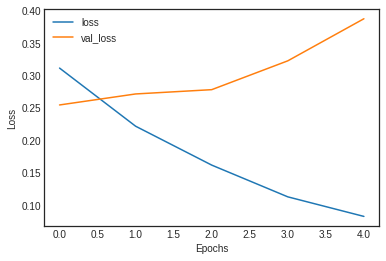

In [66]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['loss', 'val_loss']);

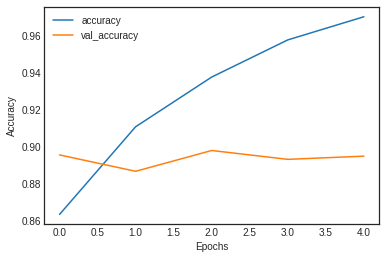

In [67]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['accuracy', 'val_accuracy']);

## 모델 평가

In [68]:
test_data_seqs, test_data_labels = [], []

for test_seq, test_label in zip(test_data['document'].values, test_data['label'].values):
  test_tokenized_text = vocab[tokenizer(clean_text(test_seq))]

  tokens = [vocab[vocab.bos_token]]
  tokens += pad_sequences([test_tokenized_text], MAX_LEN,
                          value=vocab[vocab.padding_token],
                          padding='post').tolist()[0]
  tokens += [vocab[vocab.eos_token]] 

  test_data_seqs.append(tokens)
  test_data_labels.append(test_label)

test_data_seqs = np.array(test_data_seqs, dtype=np.int64)
test_data_labels = np.array(test_data_labels, dtype=np.int64)        

In [69]:
cls_model.load_weights(ckpt_path)   #학습된 best 가중치 load해오기

cls_model.evaluate(test_data_seqs, test_data_labels, batch_size=BATCH_SIZE)

1563/1563 [==============================] - 179s 115ms/step - loss: 0.2938 - accuracy: 0.8956


[0.293795645236969, 0.8956337571144104]